### Climate skill at 1&deg;: ENSO correlation coefficients

In [1]:
from collections import namedtuple
import warnings

import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
from cartopy import crs as ccrs

from utils import get_beaker_dataset_variables
from constants import INFERENCE_COMPARISON_1DEG, CLIMSST_DEG_WANDB_RUN_IDS, SECONDS_PER_DAY

In [2]:
# beaker downloads trigger this noisy warning
warnings.filterwarnings("ignore", message='install "ipywidgets" for Jupyter support')

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
mpl.rc('font', size=8)

In [3]:
EvalVar = namedtuple("EvalVar", ("name", "long_name", "units", "conversion_factor"))

EVAL_VARS = [
    EvalVar("ULWRFtoa", "outgoing longwave radiation", "W/m^2", None),
#     EvalVar("TMP2m", "2-meter temperature", "K", None),
    EvalVar("PRATEsfc", "surface precipitation", "mm", SECONDS_PER_DAY),
]
DS_VARS = [var.name for var in EVAL_VARS]

In [4]:
inference_comparison = {}
runs_10yr = INFERENCE_COMPARISON_1DEG['10yr'].copy()
del runs_10yr['SHiELD-AMIP-vs.-ERA5']
inference_comparison['10yr'] = runs_10yr
runs_82yr = INFERENCE_COMPARISON_1DEG['82yr'].copy()
del runs_82yr['SHiELD-AMIP-vs.-ERA5']
runs_82yr['climSST-ACEv1'] = CLIMSST_DEG_WANDB_RUN_IDS
inference_comparison['82yr'] = runs_82yr

In [5]:
datasets = []
for duration_name, duration_runs in inference_comparison.items():
    for group_name, group_runs in duration_runs.items():
        if isinstance(group_runs, dict):
            for ic_name, ic_run in group_runs.items():
                full_key = '/'.join([duration_name, group_name, ic_name])
                print(f"Getting run: {full_key=}")
                ic_dataset = get_beaker_dataset_variables(ic_run, 'enso_coefficient_diagnostics.nc', DS_VARS)
                for var in EVAL_VARS:
                    if var.conversion_factor is not None:
                        ic_dataset[var.name] = var.conversion_factor * ic_dataset[var.name]
                datasets.append(
                    ic_dataset
                    .expand_dims({'duration': [duration_name], 'group': [group_name], 'IC': [ic_name]})
                )
        else:
            full_key = '/'.join([duration_name, group_name])
            print(f"Getting run: {full_key=}")
            group_dataset = get_beaker_dataset_variables(group_runs, 'enso_coefficient_diagnostics.nc', DS_VARS)
            for var in EVAL_VARS:
                if var.conversion_factor is not None:
                    group_dataset[var.name] = var.conversion_factor * group_dataset[var.name]
            datasets.append(
                group_dataset
                .expand_dims({'duration': [duration_name], 'group': [group_name]})
            )
enso_coefficient_ds = xr.merge(datasets).squeeze()

Getting run: full_key='10yr/ERA5-ACEv2'


Getting run: full_key='10yr/SHiELD-AMIP-ACEv2/IC0'


Getting run: full_key='10yr/SHiELD-AMIP-ACEv2/IC1'


Getting run: full_key='10yr/SHiELD-AMIP-ACEv2/IC2'


Getting run: full_key='10yr/SHiELD-AMIP-reference'


Getting run: full_key='82yr/ERA5-ACEv2'


Getting run: full_key='82yr/SHiELD-AMIP-ACEv2/IC0'


Getting run: full_key='82yr/SHiELD-AMIP-ACEv2/IC1'


Getting run: full_key='82yr/SHiELD-AMIP-ACEv2/IC2'


Getting run: full_key='82yr/SHiELD-AMIP-reference'


Getting run: full_key='82yr/climSST-ACEv1/IC0'


Getting run: full_key='82yr/climSST-ACEv1/IC1'


Getting run: full_key='82yr/climSST-ACEv1/IC2'


In [6]:
enso_coefficient_IC_mean = enso_coefficient_ds.mean('IC')

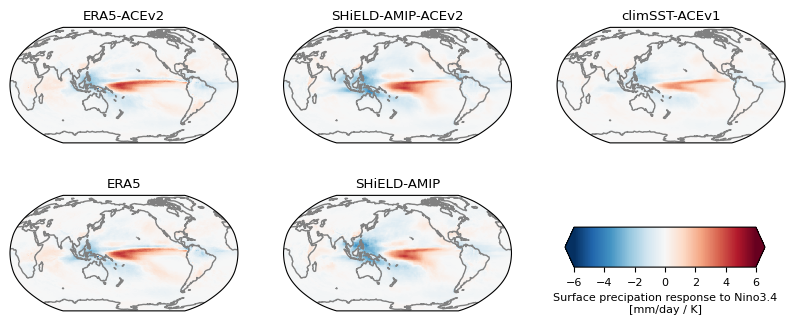

In [7]:
plot_var = 'PRATEsfc'
duration = '82yr'
plot_kwargs = dict(vmin=-6, vmax=6, cmap='RdBu_r')

fig, axes = plt.subplots(2, 3, subplot_kw=dict(projection=ccrs.Robinson(central_longitude=180)))
ax0 = axes.flatten()[0]
h = enso_coefficient_IC_mean[plot_var].sel(
    duration=duration, source='prediction', group='ERA5-ACEv2'
).plot(ax=ax0, transform=ccrs.PlateCarree(), add_colorbar=False, **plot_kwargs)
ax0.set_title('ERA5-ACEv2')
ax1 = axes.flatten()[1]
enso_coefficient_IC_mean[plot_var].sel(
    duration=duration, source='prediction', group='SHiELD-AMIP-ACEv2'
).plot(ax=ax1, transform=ccrs.PlateCarree(), add_colorbar=False, **plot_kwargs)
ax1.set_title('SHiELD-AMIP-ACEv2')
ax2 = axes.flatten()[2]
enso_coefficient_IC_mean[plot_var].sel(
    duration=duration, source='prediction', group='climSST-ACEv1'
).plot(ax=ax2, transform=ccrs.PlateCarree(), add_colorbar=False, **plot_kwargs)
ax2.set_title('climSST-ACEv1')
ax3 = axes.flatten()[3]
enso_coefficient_IC_mean[plot_var].sel(
    duration=duration, source='target', group='ERA5-ACEv2'
).plot(ax=ax3, transform=ccrs.PlateCarree(), add_colorbar=False, **plot_kwargs)
ax3.set_title('ERA5')
ax4 = axes.flatten()[4]
enso_coefficient_IC_mean[plot_var].sel(
    duration=duration, source='target', group='SHiELD-AMIP-ACEv2'
).plot(ax=ax4, transform=ccrs.PlateCarree(), add_colorbar=False, **plot_kwargs)
ax4.set_title('SHiELD-AMIP')
[ax.coastlines(color='gray') for ax in axes.flatten()[:-1]]
ax5 = axes.flatten()[5]
ax5.set_axis_off()
del ax5
ax5 = fig.add_axes([0.68, 0.25, 0.2, 0.1])
fig.colorbar(
    h, cax=ax5,
    orientation='horizontal',
    extend='both',
    ticks=np.linspace(-6, 6, 7),
    label='Surface precipation response to Nino3.4\n[mm/day / K]'
)
fig.set_size_inches([10, 4])
fig.savefig(f'enso_coefficient_maps_{plot_var}.png', bbox_inches='tight', facecolor='w')

In [8]:
# plot_var = 'ULWRFtoa'
# duration = '82yr'
# plot_kwargs = dict(vmin=-5, vmax=5, cmap='RdBu_r')

# fig, axes = plt.subplots(2, 3, subplot_kw=dict(projection=ccrs.Robinson(central_longitude=180)))
# ax0 = axes.flatten()[0]
# enso_coefficient_IC_mean[plot_var].sel(
#     duration=duration, source='prediction', group='ERA5-ACEv2'
# ).plot(ax=ax0, transform=ccrs.PlateCarree(), add_colorbar=False, **plot_kwargs)
# ax0.set_title('ERA5-ACEv2')
# ax1 = axes.flatten()[1]
# enso_coefficient_IC_mean[plot_var].sel(
#     duration=duration, source='prediction', group='SHiELD-AMIP-ACEv2'
# ).plot(ax=ax1, transform=ccrs.PlateCarree(), add_colorbar=False, **plot_kwargs)
# ax1.set_title('SHiELD-AMIP-ACEv2')
# ax2 = axes.flatten()[2]
# enso_coefficient_IC_mean[plot_var].sel(
#     duration=duration, source='prediction', group='climSST-ACEv1'
# ).plot(ax=ax2, transform=ccrs.PlateCarree(), add_colorbar=False, **plot_kwargs)
# ax2.set_title('climSST-ACEv1')
# ax3 = axes.flatten()[3]
# enso_coefficient_IC_mean[plot_var].sel(
#     duration=duration, source='target', group='ERA5-ACEv2'
# ).plot(ax=ax3, transform=ccrs.PlateCarree(), add_colorbar=False, **plot_kwargs)
# ax3.set_title('ERA5')
# ax4 = axes.flatten()[4]
# enso_coefficient_IC_mean[plot_var].sel(
#     duration=duration, source='target', group='SHiELD-AMIP-ACEv2'
# ).plot(ax=ax4, transform=ccrs.PlateCarree(), add_colorbar=False, **plot_kwargs)
# ax4.set_title('SHiELD-AMIP')
# ax5 = axes.flatten()[5]
# ax5.set_axis_off()
# [ax.coastlines(color='gray') for ax in axes.flatten()[:-1]]
# fig.set_size_inches([10, 4])

In [9]:
# plot_var = 'TMP2m'
# duration = '82yr'
# plot_kwargs = dict(vmin=-5, vmax=5, cmap='RdBu_r')

# fig, axes = plt.subplots(2, 3, subplot_kw=dict(projection=ccrs.Robinson(central_longitude=180)))
# ax0 = axes.flatten()[0]
# enso_coefficient_IC_mean[plot_var].sel(
#     duration=duration, source='prediction', group='ERA5-ACEv2'
# ).plot(ax=ax0, transform=ccrs.PlateCarree(), add_colorbar=False, **plot_kwargs)
# ax0.set_title('ERA5-ACEv2')
# ax1 = axes.flatten()[1]
# enso_coefficient_IC_mean[plot_var].sel(
#     duration=duration, source='prediction', group='SHiELD-AMIP-ACEv2'
# ).plot(ax=ax1, transform=ccrs.PlateCarree(), add_colorbar=False, **plot_kwargs)
# ax1.set_title('SHiELD-AMIP-ACEv2')
# ax2 = axes.flatten()[2]
# enso_coefficient_IC_mean[plot_var].sel(
#     duration=duration, source='prediction', group='climSST-ACEv1'
# ).plot(ax=ax2, transform=ccrs.PlateCarree(), add_colorbar=False, **plot_kwargs)
# ax2.set_title('climSST-ACEv1')
# ax3 = axes.flatten()[3]
# enso_coefficient_IC_mean[plot_var].sel(
#     duration=duration, source='target', group='ERA5-ACEv2'
# ).plot(ax=ax3, transform=ccrs.PlateCarree(), add_colorbar=False, **plot_kwargs)
# ax3.set_title('ERA5')
# ax4 = axes.flatten()[4]
# enso_coefficient_IC_mean[plot_var].sel(
#     duration=duration, source='target', group='SHiELD-AMIP-ACEv2'
# ).plot(ax=ax4, transform=ccrs.PlateCarree(), add_colorbar=False, **plot_kwargs)
# ax4.set_title('SHiELD-AMIP')
# ax5 = axes.flatten()[5]
# ax5.set_axis_off()
# [ax.coastlines(color='gray') for ax in axes.flatten()[:-1]]
# fig.set_size_inches([10, 4])